# Practical problem - Homework 5

Name: Ali Abbasi

Student Number: 98105879

In [1]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.distance import cdist  # I'm just using this library in order to get distance matrix more easily
import random

In [2]:
#load the input image
def load_img(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    img = np.asarray(img, dtype="int32")
    image_pixels = np.reshape(img, (-1, img.shape[2]))
    return image_pixels, img.shape

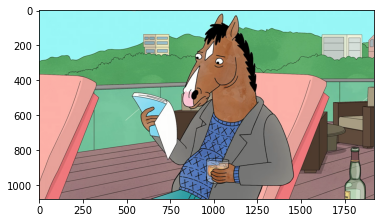

In [3]:
#write the name of your image here
image_name = 'bojack.png'
img, img_shape = load_img(image_name)

In [4]:
#determine number of desired classes here:
number_of_classes = 3

We will set number of clusters to a better choice using elbow finding later on. And also I'm gonna use color of center of each cluster as that cluster's color.

In [5]:
def get_distance_matrix(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return cdist(x, y, 'euclidean') ** 2

class K_means:

    def __init__(self, data: np.ndarray, number_of_clusters):
        self.data: np.ndarray = data
        self.number_of_clusters = number_of_clusters
        self.n, self.d = data.shape  # number of data points and feature size
        self.centers: np.ndarray = None  # set when fit is called
        self.predictions: np.ndarray = None  # set when fit is called

    def kmeans_plus_plus(self):
        centers = np.zeros((self.number_of_clusters, self.d))
        centers[0] = random.choice(self.data)
        for i in range(1, self.number_of_clusters):
            centers[i] = random.choices(self.data, weights=np.amin(get_distance_matrix(centers[:i], self.data), axis=0))[0]
        return centers

    def fit(self, max_number_of_iteration):
        predictions = None
        centers = self.kmeans_plus_plus()
        for i in range(max_number_of_iteration):
            predictions = get_distance_matrix(centers, self.data).argmin(axis=0)
            prev_centers = centers.copy()
            for j in range(self.number_of_clusters):
                cluster_j = self.data[predictions == j]
                if len(cluster_j) > 0:
                    centers[j] = cluster_j.mean(axis=0)

            if (prev_centers == centers).all():
                break

        self.centers = centers
        self.predictions = predictions
        return self.centers, self.predictions

    def get_distortion(self):
        return np.amin(get_distance_matrix(self.centers, self.data), axis=0).sum()

For GMM, we need to use arrays and vectorized operations as much as possible.
I have used einsum and broadcasting for this porpuse where ever possible. </br>
(note: I tried to comment every step and have introduced all impotant variables used in code)

In [6]:
class GMM:

    def __init__(self, number_of_classes, initial_mu, initial_sigma, initial_priors):
        """
        introducing used variables:
        x: (N, d) data points
        pi: (K,) priors
        mu: (K, d) means -> mu[i] = mean of cluster i
        sigma: (K, d, d) covariance matrices -> sigma[i] = covariance matrix of cluster i
        gamma: (N, K) beliefs -> gamma[n, k]: how much likely that x[n] belongs to k-th cluster
        normals: (N, K) -> normals[n, k] = N(x[n]|mu[k], sigma[k])
        diff: (N, K, d) for using in calculating normal distributions -> diff[n, k] = x[n] - mu[k]
        """

        self.k = number_of_classes
        self.mu: np.ndarray = np.asarray(initial_mu)
        self.sigma: np.ndarray = np.asarray(initial_sigma)
        self.pi: np.ndarray = np.asarray(initial_priors)

    # E-step
    def inference(self, x: np.ndarray, normals):
        n, d = x.shape
        tmp = np.einsum('nk, k -> nk', normals, self.pi)
        gamma = tmp / tmp.sum(axis=1).reshape(n, 1)
        return gamma

    # M-step
    def update(self, x: np.ndarray, gamma: np.ndarray):
        n, d = x.shape
        N_k = gamma.sum(axis=0)
        self.pi = N_k / n
        self.mu = np.einsum('nk, nd -> kd', gamma, x) / N_k.reshape(self.k, 1)
        diff = self.get_diff(x)
        self.sigma = np.einsum('nki, nkj -> kij',
                               np.einsum('nk, nki -> nki', gamma, diff),
                               diff) / N_k.reshape(self.k, 1, 1)

    def get_normals(self, x: np.ndarray):
        # exponent (N, K) -> exponent[n, k] = diff[n, k].T * sigma^-1[k] * diff[n, k]
        #                                   = sum over (i, j): diff[n, k, i] * sigma^-1[k, i, j] * diff[n, k, j]
        n, d = x.shape
        diff = self.get_diff(x)
        exponent = np.einsum('nkj, nkj -> nk',
                             np.einsum('nki, kij -> nkj', diff, np.linalg.inv(self.sigma)),
                             diff)
        normals = np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.sigma)) / ((2 * np.pi) ** d / 2)
        return normals

    def get_diff(self, x):
        n, d = x.shape
        # calculating diff using broadcasting
        # x: (N, d) and mu: (K, d) should result in diff: (N, k, d)
        # so we reshape x and mu: x (N, 1, d) and mu (1, K, d)
        return x.reshape((n, 1, d)) - self.mu.reshape((1, self.k, d))

    def fit(self, x, max_iter, tolerance):
        log_likelihood = - np.inf
        normals = self.get_normals(x)
        for i in range(max_iter):
            self.update(x, self.inference(x, normals))
            normals = self.get_normals(x)  # brought it here so its calculated once
            prev_log_likelihood = log_likelihood
            log_likelihood = self.get_log_likelihood(x, normals)
            if log_likelihood - prev_log_likelihood < tolerance:
                break

    def get_log_likelihood(self, x, normals):
        return np.sum(np.log(self.get_p_x(x, normals)))

    def get_p_x(self, x, normals):
        return np.dot(normals, self.pi)

    def predict(self, x):
        return np.argmax(self.inference(x, self.get_normals(x)), axis=1)

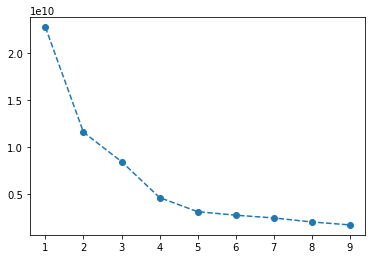

In [9]:
#use of kmeans of the image for better initialization
distortion = []
for i in range(1, 10):
    kmeans = K_means(img, i)
    kmeans.fit(1000)
    distortion.append(kmeans.get_distortion())
plt.plot(range(1, len(distortion) + 1), distortion, marker='o', linestyle = 'dashed')

As we can see in above diagram, 4 seems to be a good choice for number of clusters. We'll plot clustered image with 4 clusters using K-means. (note: for each datapoint, I have used center of its cluster as its color)

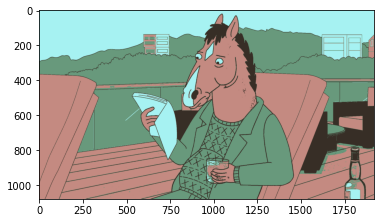

In [15]:
number_of_classes = 4
kmeans = K_means(img, number_of_classes)
kmeans.fit(1000)
clustered_img = kmeans.centers.astype(int)[kmeans.predictions].reshape(img_shape)
plt.imshow(clustered_img);

In [26]:
#calling the GMM functions
def get_initial_paramters_for_gmm(x, centers, prediction):
    k, d = centers.shape
    n = len(prediction)
    pi = np.ndarray(k)
    mu = np.ndarray((k, d))
    sigma = np.ndarray((k, d, d))
    for i in range(k):
        cluster_i_mask = prediction == i
        cluster_i = x[cluster_i_mask]
        n_i = len(cluster_i)
        pi[i] = n_i / n
        mu[i] = cluster_i.mean(axis=0)
        sigma[i] = np.cov(cluster_i.T)
    return pi, mu, sigma

# please run above cell before runing this cell
pi, mu, sigma = get_initial_paramters_for_gmm(img, kmeans.centers, kmeans.predictions)
gmm = GMM(number_of_classes, mu, sigma, pi)
gmm.fit(img, 100, 10e-20)
gmm_prediction = gmm.predict(img)
# using center of each component as color of that cluster:
gmm_result = gmm.mu.astype(int)[gmm_prediction]
gmm_clustered_img = gmm_result.reshape(img_shape)

In [17]:
#show and save results
#let the final image variable be clustered_img
def save_img(clustered_img):
    plt.imshow(clustered_img)
    final_img = cv2.cvtColor(clustered_img.astype(np.float32), cv2.COLOR_RGB2BGR)
    cv2.imwrite("result.jpg", final_img)

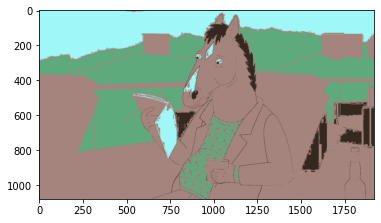

In [27]:
save_img(gmm_clustered_img)

Note: k-means did better because I had set max_iter to 1000 for it; but max_iter for GMM was 100. Because it takes a little more time :) </br>
k-means took 3 seconds and GMM about 3 minutes to run.